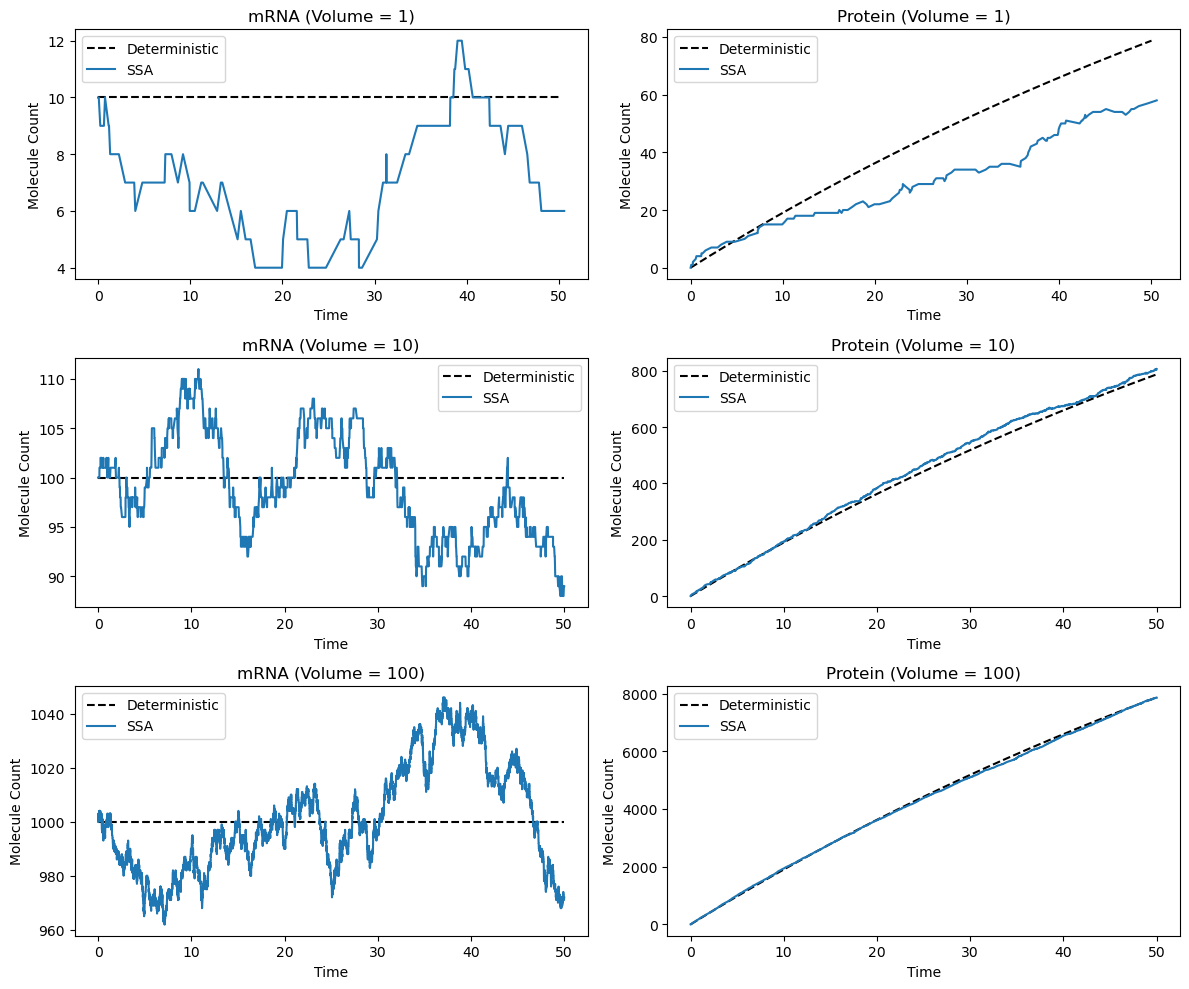

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Here we rewrite the gene expresstion definition, cause I temporaly cant open the gene_expresstion_first_example.py as a module
def gillespie_gene_expression(volume, t_max=50):
    c_mRNA = 10
    c_protein = 0
    X0 = np.array([int(c_mRNA * volume), int(c_protein * volume)])
    k_tx = 0.5 * volume
    k_deg_m = 0.05
    k_tl = 0.2
    k_deg_p = 0.01

    def prop1(x): return k_tx
    def prop2(x): return k_deg_m * x[0]
    def prop3(x): return k_tl * x[0]
    def prop4(x): return k_deg_p * x[1]

    reactions = [
        (prop1, np.array([1, 0])),
        (prop2, np.array([-1, 0])),
        (prop3, np.array([0, 1])),
        (prop4, np.array([0, -1]))
    ]

    # Continue SSA
    def gillespie_simulation(reactions, x0, t_max):
        t = 0
        x = x0.copy()
        times = [t]
        states = [x.copy()]
        while t < t_max:
            a = np.array([r[0](x) for r in reactions])
            a0 = np.sum(a)
            if a0 == 0:
                break
            r1, r2 = np.random.rand(2)
            tau = (1 / a0) * np.log(1 / r1)
            cumulative_sum = np.cumsum(a)
            reaction_index = np.searchsorted(cumulative_sum, r2 * a0)
            x += reactions[reaction_index][1]
            t += tau
            times.append(t)
            states.append(x.copy())
        return np.array(times), np.array(states)

    return gillespie_simulation(reactions, X0, t_max)

def deterministic_solution(volume, t_max=50):
    c_mRNA0 = 10
    c_protein0 = 0

    def model(z, t):
        m, p = z
        dm_dt = 0.5 - 0.05 * m
        dp_dt = 0.2 * m - 0.01 * p
        return [dm_dt, dp_dt]

    t = np.linspace(0, t_max, 500)
    sol = odeint(model, [c_mRNA0, c_protein0], t)
    return t, sol * volume

volumes = [1, 10, 100]
t_max = 50
results = {}

for V in volumes:
    t_det, x_det = deterministic_solution(V, t_max)
    t_ssa, x_ssa = gillespie_gene_expression(V, t_max)
    results[V] = {'t_det': t_det, 'x_det': x_det, 't_ssa': t_ssa, 'x_ssa': x_ssa}

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(3, 2)

for i, V in enumerate(volumes):
    ax1 = fig.add_subplot(gs[i, 0])
    ax2 = fig.add_subplot(gs[i, 1])
    
    ax1.plot(results[V]['t_det'], results[V]['x_det'][:, 0], 'k--', label='Deterministic')
    ax1.plot(results[V]['t_ssa'], results[V]['x_ssa'][:, 0], label='SSA')
    ax1.set_title(f'mRNA (Volume = {V})')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Molecule Count')
    ax1.legend()
    
    ax2.plot(results[V]['t_det'], results[V]['x_det'][:, 1], 'k--', label='Deterministic')
    ax2.plot(results[V]['t_ssa'], results[V]['x_ssa'][:, 1], label='SSA')
    ax2.set_title(f'Protein (Volume = {V})')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Molecule Count')
    ax2.legend()

plt.tight_layout()
plt.show()